# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [2]:
# TODO: Install any packages that you might need

import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)


In [3]:
# TODO: Import any packages that you might need
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
role = sagemaker.get_execution_role()

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [8]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in (v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [11]:
#TODO: Upload the data to AWS S3
session = sagemaker.Session()
bucket= session.default_bucket()
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train_data s3://${DEFAULT_S3_BUCKET}/train/

upload: train_data/1/.ipynb_checkpoints/103578-checkpoint.jpg to s3://sagemaker-us-east-1-479671984099/train/1/.ipynb_checkpoints/103578-checkpoint.jpg
upload: train_data/1/00084.jpg to s3://sagemaker-us-east-1-479671984099/train/1/00084.jpg
upload: train_data/1/00035.jpg to s3://sagemaker-us-east-1-479671984099/train/1/00035.jpg
upload: train_data/1/00048.jpg to s3://sagemaker-us-east-1-479671984099/train/1/00048.jpg
upload: train_data/1/00014.jpg to s3://sagemaker-us-east-1-479671984099/train/1/00014.jpg
upload: train_data/1/.ipynb_checkpoints/104290-checkpoint.jpg to s3://sagemaker-us-east-1-479671984099/train/1/.ipynb_checkpoints/104290-checkpoint.jpg
upload: train_data/1/00088.jpg to s3://sagemaker-us-east-1-479671984099/train/1/00088.jpg
upload: train_data/1/00148.jpg to s3://sagemaker-us-east-1-479671984099/train/1/00148.jpg
upload: train_data/1/00009.jpg to s3://sagemaker-us-east-1-479671984099/train/1/00009.jpg
upload: train_data/1/00214.jpg to s3://sagemaker-us-east-1-4796719

In [15]:
import pandas as pd
from pathlib import Path

image_dir_path = './train_data/'
paths = [path.parts[-3:] for path in
         Path(image_dir_path).rglob('*.jpg')]
df = pd.DataFrame(data=paths, columns=['folder', 'class', 'Images'])
print(df)
df.to_csv('data')

           folder               class                Images
0      train_data                   4             02573.jpg
1      train_data                   4            101366.jpg
2      train_data                   4             04193.jpg
3      train_data                   4             07028.jpg
4      train_data                   4             09521.jpg
...           ...                 ...                   ...
10446  train_data                   3             06334.jpg
10447  train_data                   3             03823.jpg
10448           3  .ipynb_checkpoints  00039-checkpoint.jpg
10449           3  .ipynb_checkpoints  00102-checkpoint.jpg
10450           3  .ipynb_checkpoints  00083-checkpoint.jpg

[10451 rows x 3 columns]


In [21]:
#df.drop('folder',inplace=True, axis=1)
df['index'] = df.index
df.head(30)

,class,Images,index
0,4,02573.jpg,0
1,4,101366.jpg,1
2,4,04193.jpg,2
3,4,07028.jpg,3
4,4,09521.jpg,4
5,4,102257.jpg,5
6,4,01682.jpg,6
7,4,00953.jpg,7
8,4,103229.jpg,8
9,4,06218.jpg,9


In [64]:
from matplotlib import pyplot as plt
import numpy as np
count=pd.DataFrame(df['class'].value_counts())
count.drop('.ipynb_checkpoints',inplace=True,axis=0)
count.rename(columns = {'class':'count'}, inplace = True)
count['class'] = count.index
count.sort_values("class", axis = 0, ascending = True,
                 inplace = True, na_position ='last')
count.head(10)


,count,class
1,1228,1
2,2299,2
3,2666,3
4,2373,4
5,1875,5


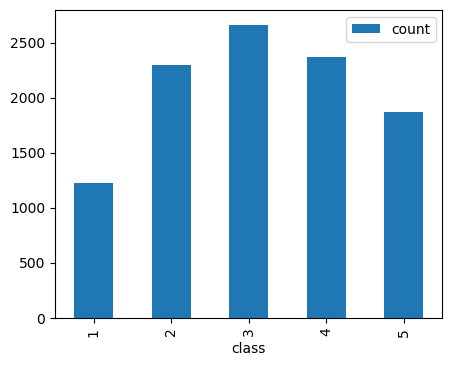

In [71]:
count.plot(x="class", y="count", kind="bar", figsize=(5, 4))
plt.show()

In [81]:

count.describe()

,count
count,5.000000
mean,2088.200000
std,557.852758
min,1228.000000
25%,1875.000000
50%,2299.000000
75%,2373.000000
max,2666.000000


## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [3]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters={"batch_size":32, "learning_rate":0.0011427}

In [4]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point='train.py',
    base_job_name='inv-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    
)

In [5]:
# TODO: Fit your estimator
estimator.fit({"training": "s3://sagemaker-us-east-1-479671984099/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: inv-pytorch-2023-03-07-17-11-06-369


2023-03-07 17:11:07 Starting - Starting the training job...
2023-03-07 17:11:26 Starting - Preparing the instances for training......
2023-03-07 17:12:13 Downloading - Downloading input data...
2023-03-07 17:12:54 Training - Downloading the training image...
2023-03-07 17:13:14 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-07 17:13:25,204 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-07 17:13:25,208 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-03-07 17:13:25,219 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-07 17:13:25,222 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-07 17:13:25,407 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.p

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [6]:
#TODO: Create your hyperparameter search space
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [7]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point="train.py",
    base_job_name='Pytorch_inventory_monitoring',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

In [8]:
# TODO: Fit your estimator
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-479671984099/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-479671984099/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-479671984099/output/'
tuner.fit({"training": "s3://sagemaker-us-east-1-479671984099/"})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230307-1754


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [9]:
# TODO: Find the best hyperparameters
best_estimator=tuner.best_estimator()


2023-03-07 18:24:15 Starting - Preparing the instances for training
2023-03-07 18:24:15 Downloading - Downloading input data
2023-03-07 18:24:15 Training - Training image download completed. Training in progress.
2023-03-07 18:24:15 Uploading - Uploading generated training model
2023-03-07 18:24:15 Completed - Resource reused by training job: pytorch-training-230307-1754-002-07db1059


### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [10]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"256"',
 'learning_rate': '0.025037840689045358',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Pytorch_inventory_monitoring-2023-03-07-17-54-36-689"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-479671984099/Pytorch_inventory_monitoring-2023-03-07-17-54-36-689/source/sourcedir.tar.gz"'}

In [4]:
hyperparameters = {"batch_size":256,
                   "learning_rate":0.025037840689045358}
hyperparameters

{'batch_size': 256, 'learning_rate': 0.025037840689045358}

In [5]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [6]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point='train.py',
    base_job_name='Inv-Mon-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [12]:
estimator.fit({"training": "s3://sagemaker-us-east-1-479671984099/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Inv-Mon-pytorch-2023-03-08-16-44-00-439


2023-03-08 16:44:00 Starting - Starting the training job...
2023-03-08 16:44:25 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-03-08 16:45:26 Downloading - Downloading input data.............................................
2023-03-08 16:52:56 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-08 16:52:52,399 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-08 16:52:52,403 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-03-08 16:52:52,414 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-08 16:52:52,417 sagemaker_pytorch_container.training INFO     Invoking user training scri

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [13]:
# TODO: Deploy your model to an endpoint
model_location=estimator.model_data

In [5]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [17]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [33]:
# TODO: Run an prediction on the endpoint
pytorch_model = PyTorchModel(model_data="s3://sagemaker-us-east-1-479671984099/Inv-Mon-pytorch-2023-03-08-16-44-00-439/output/model.tar.gz", role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [34]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-----!

In [40]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
import requests

request_dict={ "url": "https://sagemaker-us-east-1-479671984099.s3.amazonaws.com/test/1/00152.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

In [51]:
import io
byteImgIO = io.BytesIO()
byteImg = Image.open("./train_data/1/00088.jpg")
byteImg.save(byteImgIO, "PNG")
byteImgIO.seek(0)
byteImg = byteImgIO.read()

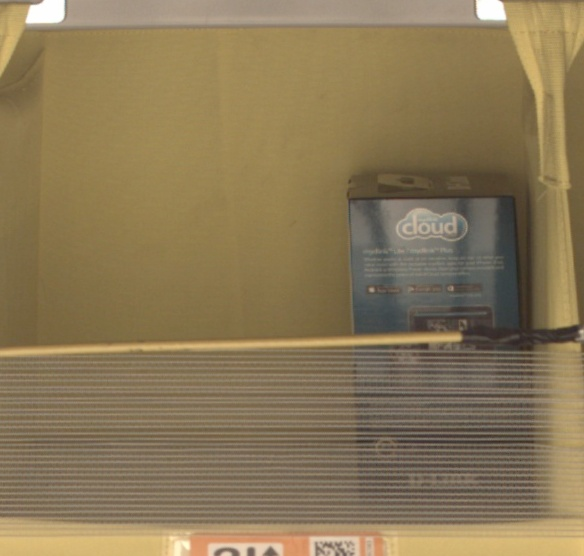

In [52]:
from PIL import Image
import io
dataBytesIO = io.BytesIO(byteImg)
Image.open(dataBytesIO)


In [53]:
response=predictor.predict(byteImg, initial_args={"ContentType": "image/jpeg"})

In [54]:

import numpy as np
np.argmax(response, 1)

array([0])